# 1. Initialization

## Imports

In [108]:
import math, random

import torch
import torch.nn as nn
from torch.nn import init, functional
from torch.utils.data import DataLoader, Dataset, random_split

import torchaudio
from torchaudio import transforms

import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinarySpecificity
from sklearn import metrics

import pandas as pd
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
from os import walk

In [109]:
#To allow plotting pytorch tensors
torch.Tensor.ndim = property(lambda self: len(self.shape))
#use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

## Constants

Audio Parameters

In [110]:
MAX_AUDIO_LENGTH = 5000
SAMPLING_RATE = 1000
N_CHANNELS = 1
SHIFT_PCT = 0.2

HOP_LENGTH=256
N_FFT=1024
N_MELS=64
N_MFCC=13 # traditional number

In [111]:
MODEL_NAME = 'model_mfcc_only_2'
IMPORT = False  #Import model state_dict if available
TEMP = False    #Import temp model state_dict if available

Hyperparameters

In [112]:
N_CLASSES = 2
N_EPOCHS = 100
STOP_EPOCHS = 10 # stop training if accuracy doesnt change for 10 epochs
BATCH_SIZE = 84


# 2. Audio Preprocessing Utilities

## AudioUtil Class
A class that includes all the methods required to load and preprocess the audio files of the dataset

In [113]:
class AudioUtil():
    @staticmethod
    def open(audio_file):

        #Open an audio file
        # print(f"Opening file : {audio_file}")
        sig, sr = torchaudio.load(audio_file)
        sig.to(device)
        return (sig, sr)
    
    @staticmethod
    def print(aud, channel):

        #Plot the audio signal wave

        sig, sr = aud
        duration = sig.shape[1]
        time = torch.linspace(0, duration/sr, duration)

        print(sig.shape)
        print('Plotting...')

        plt.figure(figsize=(15, 5))
        plt.plot(time, sig[channel - 1])
        plt.title('Audio Plot')
        plt.ylabel(' signal wave')
        plt.xlabel('time (s)')
        plt.show()

    @staticmethod
    def display_spectrogram(spec, label='Audio mel spectrogram'):
        
        #Display the audio mel spectrogram

        print(spec.shape)
        print('Plotting...')
        
        plt.figure(figsize=(5,5))
        plt.imshow(spec[0])
        plt.title(label)
        plt.ylabel('Frequency (mels)')
        plt.xlabel('Time (ms)')
        plt.colorbar(format='%+2.0f dB')

        plt.show()
    
    @staticmethod
    def display_MFCC(mfcc, label='Audio MFCCs'):
        
        #Display the audio MFCCs

        print(mfcc.shape)
        print('Plotting...')
        
        plt.figure(figsize=(5,5))
        plt.imshow(mfcc[0])
        plt.title(label)
        plt.ylabel('Index')
        plt.xlabel('Time (ms)')
        plt.colorbar(format='%+2.0f dB')

        plt.show()

    @staticmethod
    def rechannel(aud, new_channel):

        #Convert the audio from mono to stereo or vice versa

        sig, sr = aud

        if(sig.shape[0] == new_channel):
            return aud
        
        # print('Rechanneling to ' + str(new_channel))
        if(new_channel == 1):
            resig = sig[:1, :]
        else:
            resig = torch.cat([sig, sig])
        
        return ((resig, sr))

    @staticmethod
    def resample(aud, newsr):

        #Resample the audio to the newsr frequency

        sig, sr = aud
        
        if(sr == newsr):
            return
        
        # print('Resampling to ' + str(newsr))

        num_channels = sig.shape[0]
        resig_fn = torchaudio.transforms.Resample(sr, newsr).to(device)
        resig = resig_fn(sig[:1, :].to(device))
        if(num_channels > 1):
            retwo_fn = torchaudio.transforms.Resample(sr, newsr).to(device)
            retwo = retwo_fn(sig[1:, :].to(device))
            resig = torch.cat([resig, retwo])

        return((resig, newsr))

    @staticmethod
    def pad_trunc(aud, max_ms):
        #add padding, or truncate the signal to fit the max length
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if(sig_len > max_len):
            #Truncate the signal
            # print('Truncating signal to ' + str(max_ms) + ' ms')
            sig = sig[:, :max_len]
        elif(sig_len < max_len):
            #Add padding
            # print('Padding signal to ' + str(max_ms) + ' ms')
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            pad_begin = torch.zeros((num_rows, pad_begin_len)).to(device)
            pad_end = torch.zeros((num_rows, pad_end_len)).to(device)

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return ((sig, sr))

    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    @staticmethod
    def pitch_shift(aud, shift_limit):
        sig, sr = aud
        shift_amt = random.random() * shift_limit
        return (sig * shift_amt, sr)

    @staticmethod
    def get_mel_spectrogram(aud, hop_length=512, n_fft=1024, n_mels=64):
        sig, sr = aud
        top_db = 80

        mel_transformation = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        db_transformation = torchaudio.transforms.AmplitudeToDB(top_db=top_db)
        mel_transformation.to(device)
        db_transformation.to(device)
        spec = mel_transformation(sig.to(device))
        spec = db_transformation(spec.to(device))
        return spec

    @staticmethod
    def spectro_augment(spec, max_mask_pct = 0.1, n_freq_masks = 1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_max_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_max_param).to(device)(aug_spec, mask_value)
        time_mask_params = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_params).to(device)(aug_spec, mask_value)

        return aug_spec

    @staticmethod
    def get_MFCC(aud, hop_length=512, n_fft=1024, n_mels=64, n_mfcc = 64):
        sig, sr = aud
        mfcc_fn = transforms.MFCC(  sample_rate=sr,
                                    n_mfcc=n_mfcc,
                                    melkwargs={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length})
        mfcc_fn.to(device)
        return mfcc_fn(sig.to(device))
    
    @staticmethod
    def get_DeltaMFCC(mfcc):
        delta_fn = torchaudio.transforms.ComputeDeltas().to(device)
        delta_mfcc = delta_fn(mfcc)
        delta2_mfcc = delta_fn(delta_mfcc)

        return (delta_mfcc, delta2_mfcc)

    @staticmethod
    def preprocess_audio(audio_dir):
        aud = AudioUtil.open(audio_dir)
        aud = AudioUtil.rechannel(aud, N_CHANNELS)
        aud = AudioUtil.resample(aud, SAMPLING_RATE)
        aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
        aud = AudioUtil.time_shift(aud, SHIFT_PCT)
        aud = AudioUtil.pitch_shift(aud, SHIFT_PCT)
        spec = AudioUtil.get_mel_spectrogram(aud, hop_length=HOP_LENGTH, n_fft=N_FFT, n_mels=N_MELS)
        aug_spec = AudioUtil.spectro_augment(spec, n_freq_masks=2, n_time_masks=2)
        mfcc = AudioUtil.get_MFCC(aud, hop_length=HOP_LENGTH, n_fft=N_FFT, n_mels=N_MELS, n_mfcc=N_MFCC)
        mfcc_1, mfcc_2 = AudioUtil.get_DeltaMFCC(mfcc)
        
        return (aud, spec, aug_spec, mfcc, mfcc_1, mfcc_2)

### Visualizing some samples

torch.Size([1, 64, 20])
Plotting...


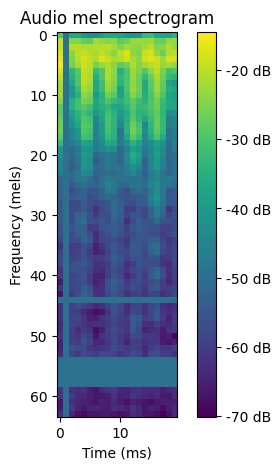

torch.Size([1, 13, 20])
Plotting...


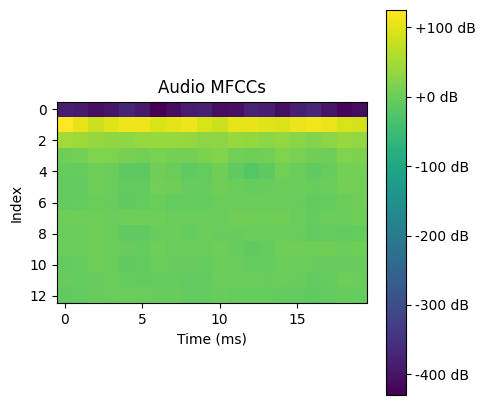

torch.Size([1, 13, 20])
Plotting...


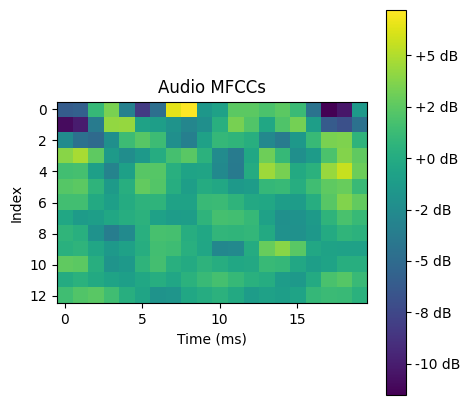

torch.Size([1, 13, 20])
Plotting...


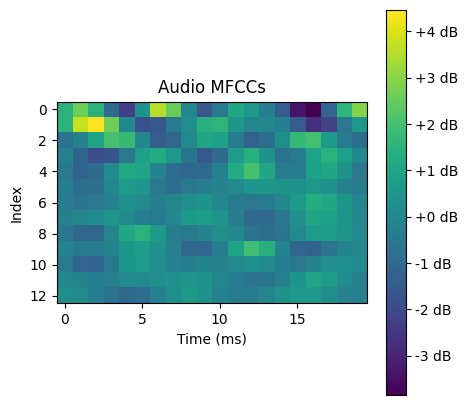

In [114]:
_, _, aug_spec, mfcc, delta_mfcc, delta2_mfcc = AudioUtil.preprocess_audio('./Dataset/PhysioNet/validation/a0001.wav')

AudioUtil.display_spectrogram(aug_spec.cpu())
AudioUtil.display_MFCC(mfcc.cpu())
AudioUtil.display_MFCC(delta_mfcc.cpu())
AudioUtil.display_MFCC(delta2_mfcc.cpu())

## Importing dataset

In [115]:
from packages.physionet_importer import getTrainingSet, getValidationSet
df = getTrainingSet()
df_val = getValidationSet()

## Sound Dataset class
Used to return a randomly preprocessed audio each time by overriding the __getitem__ function

In [116]:
class SoundDS(Dataset):
    # constructor
    def __init__(self, _df):
        super().__init__()
        self.df = _df
    
    # get length of ds
    def __len__(self):
        return len(self.df)
    
    # get i'th item in dataset
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            d = []
            start = 0 if idx.start == None else idx.start
            stop = len(self.df) if idx.stop == None else idx.stop
            for i in range(start,stop):
                try:
                    audio_file = self.df.iloc[i].relative_path
                    class_id = self.df.iloc[i].classID
                    _, _, aug_spec, mfcc, mfcc_1, mfcc_2 = AudioUtil.preprocess_audio(audio_file)
                    mfcc_cat = torch.cat([mfcc, mfcc_1, mfcc_2], dim=1)
                    # data = torch.cat(aug_spec, mfcc_cat, dim=0)
                    data = mfcc_cat
                    d.append([data, class_id])
                except:
                    print(f"An exception occurred at {i}, file: {self.df.iloc[i].relative_path}")

            return d

        audio_file = self.df.loc[idx, 'relative_path']
        class_id = self.df.loc[idx, 'classID']

        _, _, aug_spec, mfcc, mfcc_1, mfcc_2 = AudioUtil.preprocess_audio(audio_file)
        mfcc_cat = torch.cat([mfcc, mfcc_1, mfcc_2], dim=1)
        # data = torch.cat(aug_spec, mfcc_cat, dim=0)
        data = mfcc_cat
        return data, class_id

## Random split
Split the dataset into an 80:20 ratio between training and validation sets

In [117]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle data
ds = SoundDS(df)
val_ds = SoundDS(df_val)

num_items = len(ds)
num_train = round(num_items * 0.8)
num_test = num_items - num_train
train_ds, test_ds = random_split(ds, [num_train, num_test])

## Data loaders
Create training and validation data loaders

In [118]:
class_weights = 1/ df['classID'].value_counts()
sample_weights = [0] * len(train_ds)
for idx in range(len(train_ds)):
    data = train_ds[idx]
    
    label = data[1].item()
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight
sampler = torch.utils.data.WeightedRandomSampler(sample_weights,
                                                num_samples=len(sample_weights),
                                                replacement=True)

In [119]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, sampler=sampler)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

# 3. Audio Classification Model

## Creating a model instance
- Put it on the gpu if available
- Import a model if you want to

In [125]:
from packages.CNN_1 import AudioClassifier
myModel = AudioClassifier(input_dim=N_CHANNELS, output_dim=N_CLASSES)
# myModel = AudioClassifier(input_dim=2*N_CHANNELS, output_dim=N_CLASSES)

## Creating save path

In [126]:
from pathlib import Path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME_PTH = MODEL_NAME + '.pth'
MODEL_TEMP_NAME_PTH = MODEL_NAME + '_TEMP.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_PTH
MODEL_TEMP_SAVE_PATH = MODEL_PATH / MODEL_TEMP_NAME_PTH

if IMPORT:
    try:
        myModel.load_state_dict(torch.load(f=MODEL_TEMP_SAVE_PATH if TEMP else MODEL_SAVE_PATH))
    except:
        print(MODEL_TEMP_SAVE_PATH if TEMP else MODEL_SAVE_PATH + 'not found.') 

In [127]:
myModel = myModel.to(device)
# Check that it is on cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

# 4. Training Loop

## Training function

In [128]:
def training(model, train_dl, val_dl, N_EPOCHS):
    # Loss function, Optimizer and Scheduler
    loss_fn = nn.CrossEntropyLoss() #weight=torch.tensor([1.21, 1.56, 1.42, 2.63])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=int(len(train_dl)), epochs=N_EPOCHS, anneal_strategy='linear')


    # metrics for visualization
    acc_fn = BinaryAccuracy().to(device)
    precision_fn = BinaryPrecision().to(device)
    speci_fn = BinarySpecificity().to(device)
    f1_fn = BinaryF1Score().to(device)

    train_metrics = {
        'acc': [],
        'precision': [],
        'speci': [],
        'f1': [],
        'loss': [],
        'epochs': []
    }
    
    last_max_epoch = 0
    last_max_acc = 0
    # Repeat for each epoch
    for epoch in range(N_EPOCHS):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()

            # forward + backward + optimize
            model.train()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            #keep stats for loss and accuracy
            running_loss += loss.item()

            # get the predicted class with the highest score
            _, prediction = torch.max(outputs, 1)
            # count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            # test preds
            model.eval()
            with torch.inference_mode():
                for j, val_data in enumerate(val_dl):
                    val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                    # Normalize the inputs
                    val_inputs_m, val_inputs_s = val_inputs.mean(), val_inputs.std()
                    val_inputs = (val_inputs - val_inputs_m) / val_inputs_s
                    val_outputs = model(val_inputs)
                    _, val_prediction = torch.max(val_outputs, 1)
                    
                    acc_fn.update(val_prediction, val_labels)
                    precision_fn.update(val_prediction, val_labels)
                    speci_fn.update(val_prediction, val_labels)
                    f1_fn.update(val_prediction, val_labels)
        
        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        
        val_acc = acc_fn.compute().item()
        precision = precision_fn.compute().item()
        speci = speci_fn.compute().item()
        f1 = f1_fn.compute().item()

        if val_acc > last_max_acc:
            last_max_acc = val_acc
            last_max_epoch = epoch
        elif epoch - last_max_epoch < STOP_EPOCHS:
            # stop early if validation accuracy doesnt improve for 'STOP_EPOCHS' epochs
            print(f"{bcolors.WARNING}Stopped training due to no validation accuracy improvements during the last {STOP_EPOCHS} epochs{bcolors.ENDC}")
            break

        if epoch % 1 == 0:
            print(f'{bcolors.OKBLUE}Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}, Validation Accuracy: {val_acc:.2f}, Precision: {precision:.2f}, Specificity: {speci:.2f}, F1 Score: {f1:.2f}{bcolors.ENDC}')
            train_metrics['acc'].append(val_acc)
            train_metrics['precision'].append(precision)
            train_metrics['speci'].append(speci)
            train_metrics['f1'].append(f1)
            train_metrics['loss'].append(running_loss)
            train_metrics['epochs'].append(epoch)
        if epoch % 4 == 0:
            print(f"Saving model to {MODEL_TEMP_SAVE_PATH}")
            torch.save(obj=myModel.state_dict(), f=MODEL_TEMP_SAVE_PATH)
    
    print(f"{bcolors.OKGREEN}Finished Training{bcolors.ENDC}")
    return train_metrics

## Start training

In [129]:
train_metrics = training(myModel, train_dl, val_dl, N_EPOCHS)

Epoch: 0, Loss: 0.70, Accuracy: 0.49, Validation Accuracy: 0.51, Precision: 0.67, Specificity: 0.97, F1 Score: 0.10
Saving model to models\model_mfcc_only_2_TEMP.pth
Epoch: 1, Loss: 0.68, Accuracy: 0.56, Validation Accuracy: 0.53, Precision: 0.59, Specificity: 0.87, F1 Score: 0.28
Epoch: 2, Loss: 0.66, Accuracy: 0.59, Validation Accuracy: 0.54, Precision: 0.59, Specificity: 0.81, F1 Score: 0.38
Epoch: 3, Loss: 0.64, Accuracy: 0.65, Validation Accuracy: 0.56, Precision: 0.60, Specificity: 0.77, F1 Score: 0.44
Epoch: 4, Loss: 0.60, Accuracy: 0.68, Validation Accuracy: 0.58, Precision: 0.61, Specificity: 0.73, F1 Score: 0.50
Saving model to models\model_mfcc_only_2_TEMP.pth
Epoch: 5, Loss: 0.57, Accuracy: 0.70, Validation Accuracy: 0.59, Precision: 0.62, Specificity: 0.70, F1 Score: 0.54
Epoch: 6, Loss: 0.55, Accuracy: 0.72, Validation Accuracy: 0.61, Precision: 0.63, Specificity: 0.69, F1 Score: 0.57
Epoch: 7, Loss: 0.50, Accuracy: 0.76, Validation Accuracy: 0.62, Precision: 0.63, Specif

Visualize metrics

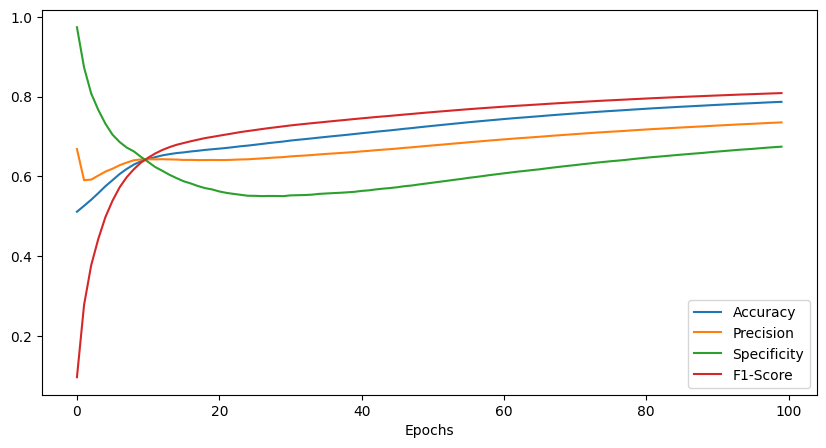

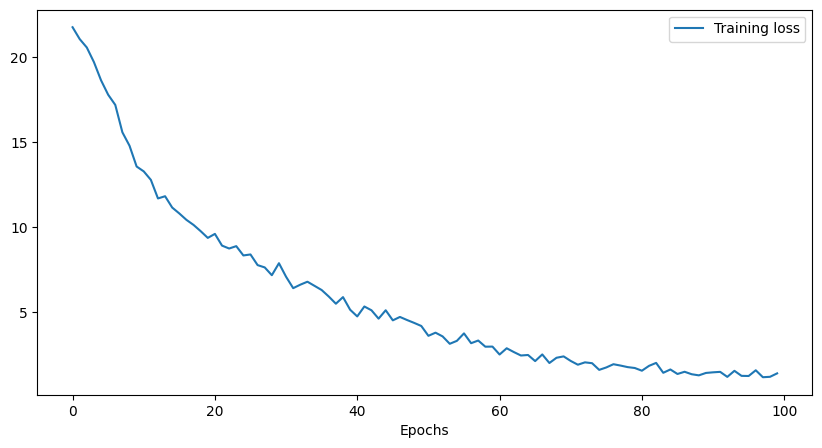

In [145]:
plt.figure(figsize=(10,5))
plt.xlabel("Epochs")

plt.plot(train_metrics['epochs'] ,train_metrics['acc'], label='Accuracy')
plt.plot(train_metrics['epochs'], train_metrics['precision'], label='Precision')
plt.plot(train_metrics['epochs'], train_metrics['speci'], label='Specificity')
plt.plot(train_metrics['epochs'], train_metrics['f1'], label='F1-Score')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.plot(train_metrics['epochs'], train_metrics['loss'], label='Training loss')
plt.legend()

Save the model after the training is complete

In [131]:
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=myModel.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\model_mfcc_only_2.pth


# 5. Evaluation
Run inference on the trained model with the test set and visualize metrics

In [132]:
def inference(model, val_dl):
    confmat_fn = torchmetrics.ConfusionMatrix(task="binary", num_classes=N_CLASSES).to(device)
    acc_fn = BinaryAccuracy().to(device)
    precision_fn = BinaryPrecision().to(device)
    speci_fn = BinarySpecificity().to(device)
    f1_fn = BinaryF1Score().to(device)

    with torch.inference_mode():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)

            acc_fn.update(prediction, labels)
            precision_fn.update(prediction, labels)
            speci_fn.update(prediction, labels)
            f1_fn.update(prediction, labels)
            confmat_fn.update(prediction, labels)
        
        acc = acc_fn.compute().item()
        precision = precision_fn.compute().item()
        speci = speci_fn.compute().item()
        f1 = f1_fn.compute().item()
        confmat = confmat_fn.compute()
        print(f'Accuracy: {acc:.2f}, Precision: {precision:.2f}, Specificity: {speci:.2f}, F1 Score: {f1:.2f}')
        cm_display = metrics.ConfusionMatrixDisplay(confmat.cpu().numpy(), display_labels=['Normal', 'Abnormal'])
        cm_display.plot()

Accuracy: 0.87, Precision: 0.71, Specificity: 0.92, F1 Score: 0.70


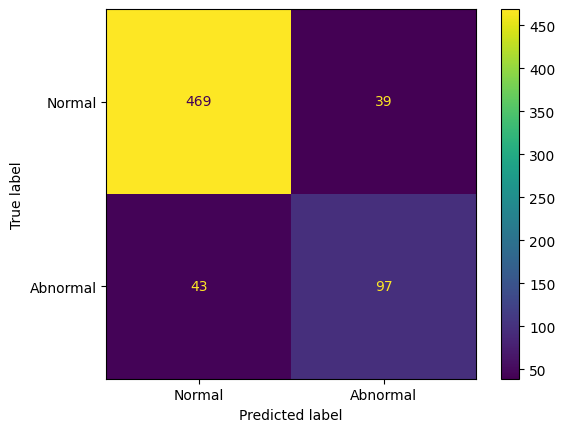

In [133]:
inference(myModel, test_dl)

# 6. Testing

In [134]:
def testing(model, data):
    model.eval()
    with torch.inference_mode():
        input = data[0].unsqueeze(dim=0).to(device)
        label = torch.tensor(data[1]).to(device)
        inputs_m, inputs_s = input.mean(), input.std()
        input = (input - inputs_m) / inputs_s
        output = model(input)
        _, prediction = torch.max(output,1)
        if prediction == label:
            print(f"{bcolors.OKGREEN}{prediction[0].item()} <--> {label}{bcolors.ENDC}")
        else:
            print(f"{bcolors.FAIL}{prediction[0].item()} <--> {label}{bcolors.ENDC}")
        

print(f"{bcolors.BOLD}predicted <--> actual{bcolors.ENDC}")
for i in range(len(val_ds)):
    testing(myModel, val_ds[i])

predicted <--> actual
1 <--> 1
0 <--> 1
0 <--> 1
1 <--> 1
1 <--> 1
1 <--> 1
0 <--> 0
1 <--> 1
0 <--> 0
1 <--> 1
0 <--> 0
0 <--> 0
1 <--> 1
0 <--> 1
1 <--> 1
0 <--> 0
1 <--> 1
1 <--> 1
0 <--> 0
0 <--> 1
1 <--> 1
0 <--> 1
1 <--> 1
1 <--> 1
1 <--> 0
1 <--> 1
0 <--> 0
0 <--> 0
0 <--> 0
1 <--> 1
0 <--> 1
0 <--> 0
1 <--> 1
1 <--> 1
0 <--> 0
1 <--> 1
1 <--> 1
0 <--> 0
1 <--> 1
0 <--> 1
0 <--> 1
1 <--> 1
1 <--> 1
0 <--> 1
1 <--> 1
1 <--> 1
0 <--> 1
1 <--> 1
0 <--> 0
0 <--> 0
0 <--> 1
1 <--> 1
1 <--> 0
1 <--> 1
0 <--> 0
0 <--> 1
1 <--> 1
0 <--> 0
0 <--> 0
1 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
1 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
0 <--> 0
1 <--> 0
1 <--> 0
0 <--> 0
1 <--> 0
0 <--> 0
0 <--> 0
1 <--> 1
1 <--> 0
0 <--> 0
1 <--> 0
0 <--> 0
1 <--> 1
1 <--> 0
0 <--> 0
1 <--> 1
0 <--> 0
1 <--> 1
1 <--> 0
0 <--> 0
1 <--> 0
0 <--> 1
1 <--> 1
1 <--> 0
0 <--> 0
1 <--> 0
0 <--> 0
0 <--> 0
0 <-->